# Deutsch-Jozsa Algorithm on a Real Device

* Implement the quantum algorithm for a generalized oracle using Qiskit
* Run it on a simulator and device.

This is a mildly mutilated version of https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html

Good references:
1. David Deutsch and Richard Jozsa (1992). "Rapid solutions of problems by quantum computation". Proceedings of the Royal Society of London A. 439: 553–558. doi:10.1098/rspa.1992.0167.
2. R. Cleve; A. Ekert; C. Macchiavello; M. Mosca (1998). "Quantum algorithms revisited". Proceedings of the Royal Society of London A. 454: 339–354. doi:10.1098/rspa.1998.0164.


First, we need to set up our modules

In [1]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

## Generalised Circuits <a id='general_circs'></a>

Before we try and run on a real machine, lets write generlized oracle. It takes the `case`, (either `'balanced'` or '`constant`', and `n`, the size of the input register:

In [14]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = ???????????
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # In the previous lab, we had a fixed bit string for our balanced oracle to wrap the CNOTs in Xs.
        # Here, let us implement a random bit string. To do so, we can simply randomly
        # sample from a random integer between 1 and 2**n.
        b = ?????????
        
        # Next, we format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        
        # Next, we want to place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # you apply an X-gate to that qubit.  This code should look like your
        # previous balanced oracle
        ????????????
                
        # Insert the controlled-NOT gates for each input qubit, using the output qubit 
        # as the target:
        ????????????
            
        # Next, place the final X-gates.   This should look like a for loop over the qubits with 
        # an if statement for based on the bit string.  As in, it should look very similar
        # to your previous for loop + if statement
        ????????????

    # Case in which oracle is constant
    if case == "constant":
        
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1).  This can be done by calling a random integer
        # of either 1 or 0.
        output = ?????????????
        
        # Write an if statement that if output is one, you apply an x gate to the output qubit
        ???????????????
    
    #Here we introduce a novel function, to_gate(). This takes a quantum circuit, like oracle_qc, and makes it
    # into a form that it can be called by other quantum circuits as a gate.
    oracle_gate = oracle_qc.to_gate()
    
    oracle_gate.name = "Oracle" # names our gate so when we draw it will have a label
    
    return oracle_gate

Let's also create a function that takes this oracle gate and performs the Deutsch-Jozsa algorithm on it:

In [15]:
def dj_algorithm(oracle, n):
    
    # Create a circuit with n+1 qubits and n classical bits (again, we don't have to measure the final state
    # of the output qubit.  The syntax for this extends what you have been using to 
    # QuantumCircuit(number_of_qubits, number_of_classical_bits)
    dj_circuit = ?????????????????
    
    # Put the output qubit into a |-> state
    ???????????????????
    
    # Create a for loop to put all n input qubits into |+> states
    ???????????????????
        
    # A new, novel function for circuits, which you are potentially familiar with
    # from python and numpy is circuit.append(gate,qubits) which adds a gate to your
    # circuit that acts on a set of qubits
    dj_circuit.append(oracle, range(n+1))
    
    # Perform the H-gates again on all the input qubits:
    ???????????????????
    
    #Here, we perform a measurement on all the input qubits
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

So how do you run this code all together?  How about we test this:

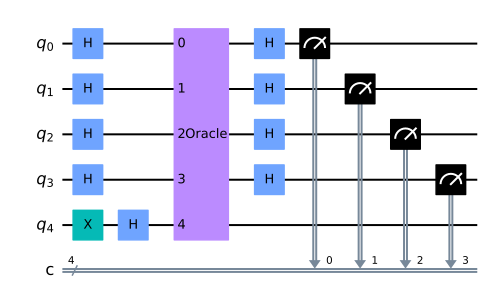

In [16]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

When using QISKIT one often needs/wants to explicitly do transpiling, because the circuit you write won't be optimized for the backend you use.  To do this, before assembling your circuit, you call 

    transpile(name_of_your_circuit, backend)
    
at minimum.  This function can take in other options, as we will see when we put it onto a real machince.

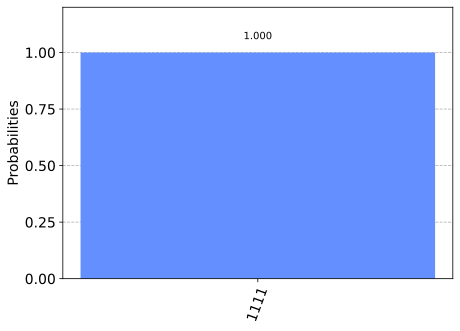

In [17]:
#Define our backend
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024

#Defining a new circuit that is transpiled to run on the aer_simulator
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)

#Assemble the quantum object
qobj = assemble(transpiled_dj_circuit)

#Run the AER simulator with our circuit and output the results
results = aer_sim.run(qobj).result()

#Here, we use the nifty feature get_counts() which outputs an dictionary of states and the frequency of them
#obtained at the end
answer = results.get_counts()

#Here is a QISKIT special histogram plotter than understands the particular format of our dictionary
plot_histogram(answer)

## 5. Experiment with Real Devices <a id='device'></a>

To run on a real machine in QISKIT is a bit more cumbersome than IBM composer.  You need a few lines of scary code to make this happen. In order to expedite the running process, I have made the backend code even scarier by having it look for the least-busy device that can handle your circuit.

In [18]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_mumbai


In [19]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


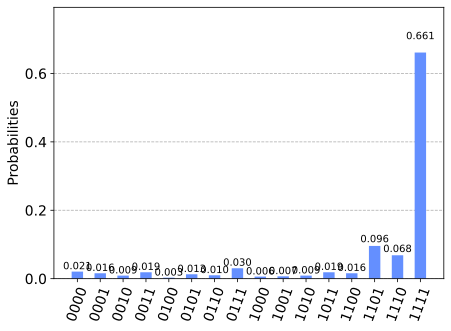

In [20]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

As we can see, the most likely result is `1111`. The other results are due to errors in the quantum computation.  Now, lets make a real oracle and <b>see if you can recognize what type of function you have been passed</b>. 

In [ ]:
n = 4

choose_oracle = ['balanced','constant']
oracle_value=np.random.choice(choose_oracle)

oracle_gate = dj_oracle(oracle_value, n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()


shots = 1024
transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)

results = job.result()
answer = results.get_counts()

plot_histogram(answer)

Which type of function do you think you ran your computer with?  To check, run the next cell

In [ ]:
print(oracle_value)